In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
df = pd.read_csv("output.csv") # dataset Jonathan created for extra data about harvey
df.head()

,Latitude,Longitude,Elevation,Dataset,FilePath,ContainingFolder,Status
0,30.987438,-93.528502,30.068228,ned10m,DamageDetection\damage\-93.528502_30.987438.jpeg,DamageDetection,damaged
1,30.988157,-93.530200,29.918272,ned10m,DamageDetection\damage\-93.5302_30.988157.jpeg,DamageDetection,damaged
2,30.982944,-93.539510,29.212812,ned10m,DamageDetection\damage\-93.53950999999999_30.9...,DamageDetection,damaged
3,30.982434,-93.539521,29.003891,ned10m,DamageDetection\damage\-93.539521_30.982434.jpeg,DamageDetection,damaged
4,30.982689,-93.540151,29.006647,ned10m,DamageDetection\damage\-93.540151_30.982689.jpeg,DamageDetection,damaged


In [35]:
# transform
df['Damaged'] = df['Status'].map({'damaged': True, 'undamaged': False})
df.head()

,Latitude,Longitude,Elevation,Dataset,FilePath,ContainingFolder,Status,Damaged
0,30.987438,-93.528502,30.068228,ned10m,DamageDetection\damage\-93.528502_30.987438.jpeg,DamageDetection,damaged,True
1,30.988157,-93.530200,29.918272,ned10m,DamageDetection\damage\-93.5302_30.988157.jpeg,DamageDetection,damaged,True
2,30.982944,-93.539510,29.212812,ned10m,DamageDetection\damage\-93.53950999999999_30.9...,DamageDetection,damaged,True
3,30.982434,-93.539521,29.003891,ned10m,DamageDetection\damage\-93.539521_30.982434.jpeg,DamageDetection,damaged,True
4,30.982689,-93.540151,29.006647,ned10m,DamageDetection\damage\-93.540151_30.982689.jpeg,DamageDetection,damaged,True


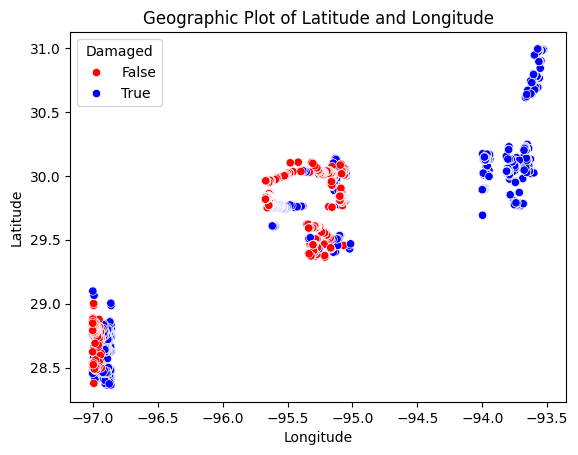

In [45]:
sns.scatterplot(data=df, x='Longitude', y='Latitude',
                hue='Damaged', palette={True: 'blue', False: 'red'}, legend='full')
plt.title('Geographic Plot of Latitude and Longitude')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

This looks quite striking! Damage vs no damage seems to be almost entirely dependent on neighborhood, nothing to do with the images themselves. Intuitively this makes sense. Lets see if we can do a k nearest neighbors super simple model and see what accuracy it gets

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

X = df[['Latitude', 'Longitude']] 
y = df['Damaged'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

for n_neighbors in range(5,105,5):
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Neighbors: {n_neighbors}\tAccuracy: {accuracy * 100:.2f}%")


Neighbors: 5	Accuracy: 54.61%
Neighbors: 10	Accuracy: 58.79%
Neighbors: 15	Accuracy: 58.92%
Neighbors: 20	Accuracy: 60.63%
Neighbors: 25	Accuracy: 60.50%
Neighbors: 30	Accuracy: 61.37%
Neighbors: 35	Accuracy: 61.16%
Neighbors: 40	Accuracy: 62.00%
Neighbors: 45	Accuracy: 62.12%
Neighbors: 50	Accuracy: 62.39%
Neighbors: 55	Accuracy: 62.36%
Neighbors: 60	Accuracy: 63.06%
Neighbors: 65	Accuracy: 62.62%
Neighbors: 70	Accuracy: 63.13%
Neighbors: 75	Accuracy: 63.09%
Neighbors: 80	Accuracy: 63.61%
Neighbors: 85	Accuracy: 63.46%
Neighbors: 90	Accuracy: 63.70%
Neighbors: 95	Accuracy: 63.50%
Neighbors: 100	Accuracy: 63.75%


Ok so 64% isn't great... Now what about a simple neural network?

In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

X = df[['Latitude', 'Longitude', 'Elevation']]
y = df['Damaged'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the model
model = Sequential()
model.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Single output neuron for binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Epoch 1/30


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


779/779 ━━━━━━━━━━━━━━━━━━━━ 1s 527us/step - accuracy: 0.6610 - loss: 0.5911 - val_accuracy: 0.6560 - val_loss: 0.5264
Epoch 2/30
779/779 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - accuracy: 0.6591 - loss: 0.5291 - val_accuracy: 0.6597 - val_loss: 0.5170
Epoch 3/30
779/779 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - accuracy: 0.6612 - loss: 0.5193 - val_accuracy: 0.6682 - val_loss: 0.5139
Epoch 4/30
779/779 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - accuracy: 0.6614 - loss: 0.5231 - val_accuracy: 0.6617 - val_loss: 0.5116
Epoch 5/30
779/779 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - accuracy: 0.6566 - loss: 0.5207 - val_accuracy: 0.6614 - val_loss: 0.5104
Epoch 6/30
779/779 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - accuracy: 0.6574 - loss: 0.5199 - val_accuracy: 0.6701 - val_loss: 0.5065
Epoch 7/30
779/779 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - accuracy: 0.6677 - loss: 0.5149 - val_accuracy: 0.6694 - val_loss: 0.5051
Epoch 8/30
779/779 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - accuracy: 0.6553 - loss: 0.5182 - val_accurac

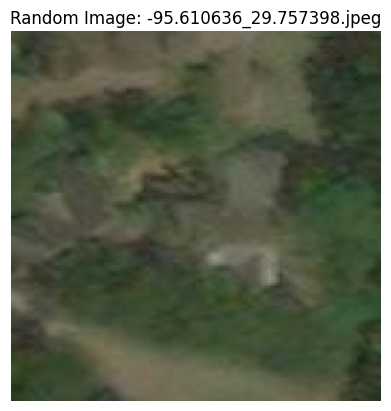

In [246]:


import matplotlib.pyplot as plt
import os
import random

# Define the path to the directory containing images
image_directory = 'test_another/damage'  # Replace with your actual image directory

# Get a list of all image files in the directory
image_files = [f for f in os.listdir(image_directory) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif'))]

# Check if there are images in the directory
if image_files:
    # Select a random image
    random_image = random.choice(image_files)
    
    # Load and display the image
    image_path = os.path.join(image_directory, random_image)
    image = plt.imread(image_path)
    
    plt.imshow(image)
    plt.axis('off')  # Hide the axes for a cleaner display
    plt.title(f"Random Image: {random_image}")  # Optional: Show the image filename
    plt.show()
else:
    print("No images found in the specified directory.")

In [247]:
l = os.listdir("damage/")
len(l)

14284